In [1]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem


In [2]:
def jaccard_similarity(list1, list2):
    if list1 is not None and list2 is not None and len(list1) > 0 and len(list2) > 0:
        list1 = [item.lower() for item in list1]
        list2 = [item.lower() for item in list2]

        set1 = set(list1)
        set2 = set(list2)
        intersection = len(set1.intersection(set2))
        union = len(set1) + len(set2) - intersection
        if union == 0:
            return 0.0
        else:
            jaccard_similarity = intersection / union
            return jaccard_similarity
    else:
        return 0.0
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp

def get_hyperparam_perf(files):
    llm_performance_list = []
    for file in tqdm(files):
        df = pd.read_csv(os.path.join(PARENT_PATH, file))
        df.dropna(subset=["llm_answer"], inplace=True)
        llm_performance_list_across_questions = []
        for index, row in df.iterrows():
            ground_truth = ast.literal_eval(row["central_nodes_groundTruth"])
            try:
                llm_answer = json.loads(row["llm_answer"])
            except:
                try:
                    llm_answer = ast.literal_eval(row["llm_answer"].split("Nodes:")[-1])
                except:
                    llm_answer = []
            if not isinstance(llm_answer, list):
                llm_result = llm_answer["Nodes"]
            else:
                llm_result = llm_answer
            llm_performance_list_across_questions.append(jaccard_similarity(ground_truth, llm_result))
        llm_performance_list.append((np.mean(llm_performance_list_across_questions), np.std(llm_performance_list_across_questions), sem(llm_performance_list_across_questions), row["context_volume"]))
    hyperparam_perf = pd.DataFrame(llm_performance_list, columns=["performance_mean", "performance_std", "performance_sem", "context_volume"])
    return hyperparam_perf


In [3]:
'''
Following files can be obtained by running the run_two_disease_entity_hyperparameter_tuning.py script.
Make sure to change the parent path and filenames based on where and how you save the files
'''

PARENT_PATH = "../data/results"


FILES_1 = [
    "minilm_based_two_disease_hyperparam_tuning_round_1_gpt_4.csv",
    "minilm_based_two_disease_hyperparam_tuning_round_2_gpt_4.csv",
    "minilm_based_two_disease_hyperparam_tuning_round_3_gpt_4.csv",
    "minilm_based_two_disease_hyperparam_tuning_round_4_gpt_4.csv",
    "minilm_based_two_disease_hyperparam_tuning_round_5_gpt_4.csv"
]

FILES_2 = [
    "pubmert_based_two_disease_hyperparam_tuning_round_1_gpt_4.csv",
    "pubmert_based_two_disease_hyperparam_tuning_round_2_gpt_4.csv",
    "pubmert_based_two_disease_hyperparam_tuning_round_3_gpt_4.csv",
    "pubmert_based_two_disease_hyperparam_tuning_round_4_gpt_4.csv",
    "pubmert_based_two_disease_hyperparam_tuning_round_5_gpt_4.csv"
]

In [4]:
mini_lm_perf = get_hyperparam_perf(FILES_1)
pubmedBert_perf = get_hyperparam_perf(FILES_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.61it/s]


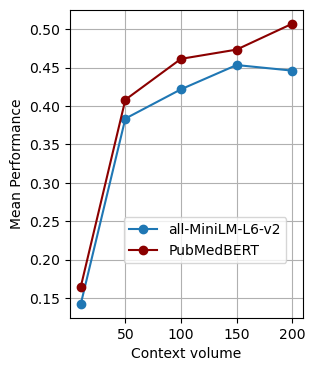

In [6]:
params = mini_lm_perf.context_volume.values
mini_lm_mean_performance = mini_lm_perf.performance_mean.values
mini_lm_std_deviation = mini_lm_perf.performance_std.values
mini_lm_sem_value = mini_lm_perf.performance_sem.values

pubmedBert_mean_performance = pubmedBert_perf.performance_mean.values
pubmedBert_std_deviation = pubmedBert_perf.performance_std.values
pubmedBert_sem_value = pubmedBert_perf.performance_sem.values

fig = plt.figure(figsize=(3, 4))
plt.errorbar(params, mini_lm_mean_performance, yerr=None, fmt='o-', capsize=5, label='all-MiniLM-L6-v2')
plt.errorbar(params, pubmedBert_mean_performance, yerr=None, fmt='o-', capsize=5, label='PubMedBERT', color="darkred")
plt.xlabel('Context volume')
plt.ylabel('Mean Performance')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.2, 0.35))
plt.show()

fig_filename = "../data/results/figures/context_volume_two_disease_prompt_miniLM_vs_PubMedBert.svg"
fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [7]:
round(mini_lm_perf.performance_mean.mean(), 2)


0.37

In [8]:
round(pubmedBert_perf.performance_mean.mean(), 2)


0.4

In [9]:
100*(round(pubmedBert_perf.performance_mean.mean(), 2) - round(mini_lm_perf.performance_mean.mean(), 2))/round(mini_lm_perf.performance_mean.mean(), 2)


8.108108108108116